In [30]:
import sys
if '/disks/cosmodm/vdvuurst' not in sys.path:
    sys.path.append('/disks/cosmodm/vdvuurst')

import numpy as np
import h5py
from matplotlib import pyplot as plt
import os
from importlib import reload
import json
import ONEHALO
from tqdm import tqdm
from functions import modified_logspace, Romberg
import glob
import onehalo_plotter
onehalo_plotter.format_plot()

In [ ]:
# for (root, dits, files) in os.walk('/disks/cosmodm/vdvuurst/figures/emcee_results_radial_bins'):
#     for file in files:
#         filepath = os.path.join(root,file)
#         if os.path.isfile(filepath):
#             if '_corner' not in file:
#                 if '_walkers' not in file:
#                     if '_fit' not in file:
#                         os.remove(filepath)

### Function fitting to params test

In [3]:
method = 'emcee'
rootpath = f'/disks/cosmodm/vdvuurst/data/OneHalo_param_fits/{method}'
rbins = modified_logspace(0, 5, 18)
rbin_centers = np.array([np.mean(rbins[i:i+2]) for i in range(17)])


def radial_param_scraper(rootpath, lower_mass = 2, upper_mass = 5.5, step = 0.5, rbins = rbins, save = False):
    mass_range = np.arange(lower_mass, upper_mass + step, step).astype(np.float32)
    mass_bins = [f'M_1{mass_range[i]}-1{mass_range[i+1]}' for i in range(len(mass_range)-1)]

    rbin_keys = np.array([f'r_{rbins[i]:.2f}-{rbins[i+1]:.2f}' for i in range(len(rbins) - 1)])

    params = ['sigma_1', 'sigma_2', 'lambda']

    mass_dict = {mass_bin: {p:np.full(rbin_centers.shape, -1, dtype = np.float32) for p in params} for mass_bin in mass_bins}
    for mass_bin in mass_bins:
        mass_dict[mass_bin]['sigma1_errors'] = np.full((*rbin_centers.shape,2), 0, dtype = np.float32)
        mass_dict[mass_bin]['sigma2_errors'] = np.full((*rbin_centers.shape,2), 0, dtype = np.float32)
        mass_dict[mass_bin]['lambda_errors'] = np.full((*rbin_centers.shape,2), 0, dtype = np.float32)

    for subdir, _, files in os.walk(rootpath):
        for file in files:
            if 'r_' in file and 'log' not in file: 
                mass_bin_str = os.path.split(subdir)[1]
                rbin_str = file.split('.json')[0]
                filepath = os.path.join(subdir, file)
                
                with open(filepath, 'r') as handle:
                    data = json.load(handle)
                
                r_index = np.where(rbin_keys == rbin_str)[0][0]

                for key,value in data.items():
                    try:
                        if key in ['nwalkers', 'nsteps']:
                            continue
                        elif key == 'errors':
                            sigma1err, sigma2err, lambdaerr = value
                            mass_dict[mass_bin_str]['sigma1_errors'][r_index] = sigma1err
                            mass_dict[mass_bin_str]['sigma2_errors'][r_index] = sigma2err
                            mass_dict[mass_bin_str]['lambda_errors'][r_index] = lambdaerr
                        else:
                            mass_dict[mass_bin_str][key][r_index] = value 
                    #TODO: with the try/except i do no errors for minimize now. but they should be just 0
                    except KeyError:
                        continue 

    #numpy to list
    for mbin in mass_bins:
        for p in params:
            data = mass_dict[mbin][p]
            mass_dict[mbin][p] = data.tolist()

    if save:
        with open(f'/disks/cosmodm/vdvuurst/data/OneHalo_param_fits/{method}/full_radial.json', 'w') as file:
            json.dump(mass_dict, file, indent = 1)
    
    return mass_dict

mass_dict = radial_param_scraper(rootpath)
# mass_dict['M_12.0-12.5']['sigma_1']

In [4]:
from scipy.optimize import curve_fit

def const_func(r,a):
    return np.full_like(r, a)

def linear_func(r, m, c):
    return m * r + c

def parabola_func(r, a, b, c):
    return a * r**2 + b * r + c

def exp_func(r, A, B, C):
    return A * np.exp(-B * r) + C

def exp_sq_func(r, A, B, C):
    return A * np.exp(-B * r**2) + C

def power_law_func(r, p, n, q):
    return p * np.power(r, n) + q

def power_linear_func(r, p, n, q, b):
    return p * np.power(r, n) + q * r + b

format_plot()

with open('/disks/cosmodm/vdvuurst/data/initial_params.json', 'r') as file:
    initial_params_full = json.load(file)


latex_formatter = {'sigma_1':r'$\sigma_1$', 'sigma_2': r'$\sigma_2$', 'lambda':r'$\lambda$'}

def fit_previous_best(switch_sigmas = True):

    for key, mass_bin_dict in mass_dict.items():
    # mass_bin_dict = mass_dict['M_12.5-13.0']

        # print(initial_params)
        if key in ['M_12.0-12.5','M_12.5-13.0','M_15.0-15.5']: # these are all 0 since Sowmya didn't do them before
            mkey = 'M_13.5-14.0'
        else:
            mkey = key
        initial_params = initial_params_full[mkey]

        sigma_1_init = np.array([initial_params[x] for x in ['p', 'n', 'q', 'b']])
        sigma_2_init = np.array([initial_params[x] for x in ['m', 'c']])
        lambda_init = np.array([initial_params[x] for x in ['A', 'B', 'C']])

        fig, axes = plt.subplots(nrows = 3, figsize = (10,10), sharex = False)
        for i,(param, values) in enumerate(mass_bin_dict.items()):
            # axes[i].set_title(latex_formatter[param])
            if 'errors' in param:
                continue
        
            match param:
                case 'sigma_1':
                    p0 = sigma_1_init
                    fit_func = power_linear_func
                    err = mass_bin_dict['sigma1_errors']

                case 'sigma_2':
                    p0 = sigma_2_init
                    fit_func = linear_func
                    err = mass_bin_dict['sigma2_errors']

                case 'lambda':
                    p0 = lambda_init
                    fit_func = exp_func
                    err = mass_bin_dict['lambda_errors']

            valid_idx = np.array(values) != -1
            try:
                popt, pcov = curve_fit(fit_func, xdata = rbin_centers[valid_idx], ydata = np.array(values)[valid_idx], p0 = p0, maxfev = 5000,
                                        sigma = np.mean(err[valid_idx], axis = 1))
                err_flag = False
            except RuntimeError:
                err_flag = True

            axes[i].errorbar(rbin_centers[valid_idx], np.array(values)[valid_idx], yerr = err[valid_idx].transpose(), fmt = '.', capsize = 2, color = 'black')

            if not err_flag:
                xvalues = np.linspace(np.min(rbin_centers[valid_idx]),np.max(rbin_centers[valid_idx]), 1000)
                match param:
                    case 'sigma_1':
                        yvalues = power_linear_func(xvalues, *popt)
                    case 'sigma_2':
                        yvalues = linear_func(xvalues, *popt)
                    case 'lambda':
                        yvalues = exp_func(xvalues, *popt)

                axes[i].plot(xvalues, yvalues, c = 'black')

            axes[i].set(ylabel = latex_formatter[param])
            axes[i].set(xlabel = 'r')
            axes[i].ticklabel_format(useOffset=False)

        plt.suptitle(key.replace('_',' = ')+' dex', fontsize = 20)
        plt.tight_layout()
        plt.show()
    
# fit_previous_best()

/var/tmp/vdvuurst/ipykernel_1490865/2740186551.py:13: RuntimeWarning: overflow encountered in exp
  return A * np.exp(-B * r) + C
/var/tmp/vdvuurst/ipykernel_1490865/2740186551.py:16: RuntimeWarning: overflow encountered in exp
  return A * np.exp(-B * r**2) + C


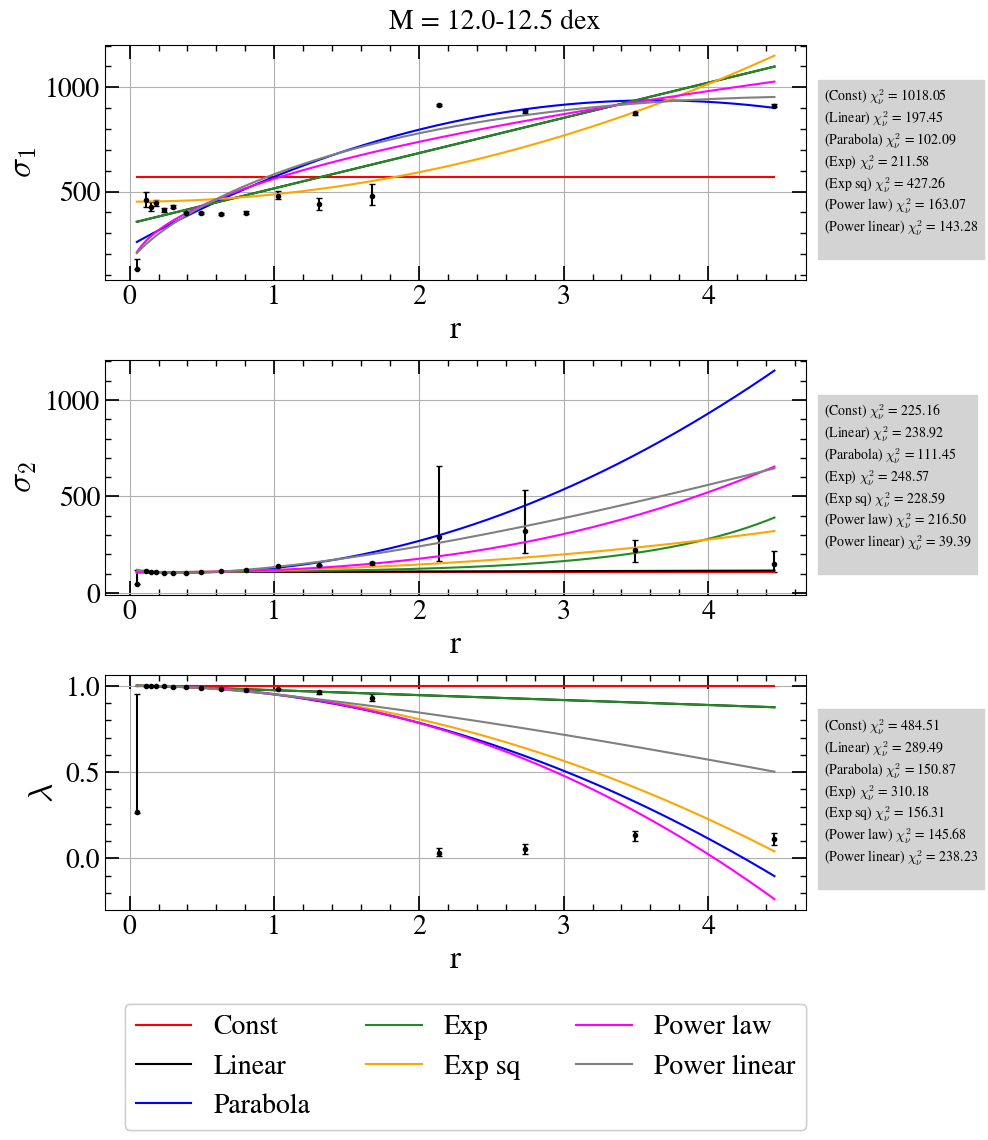

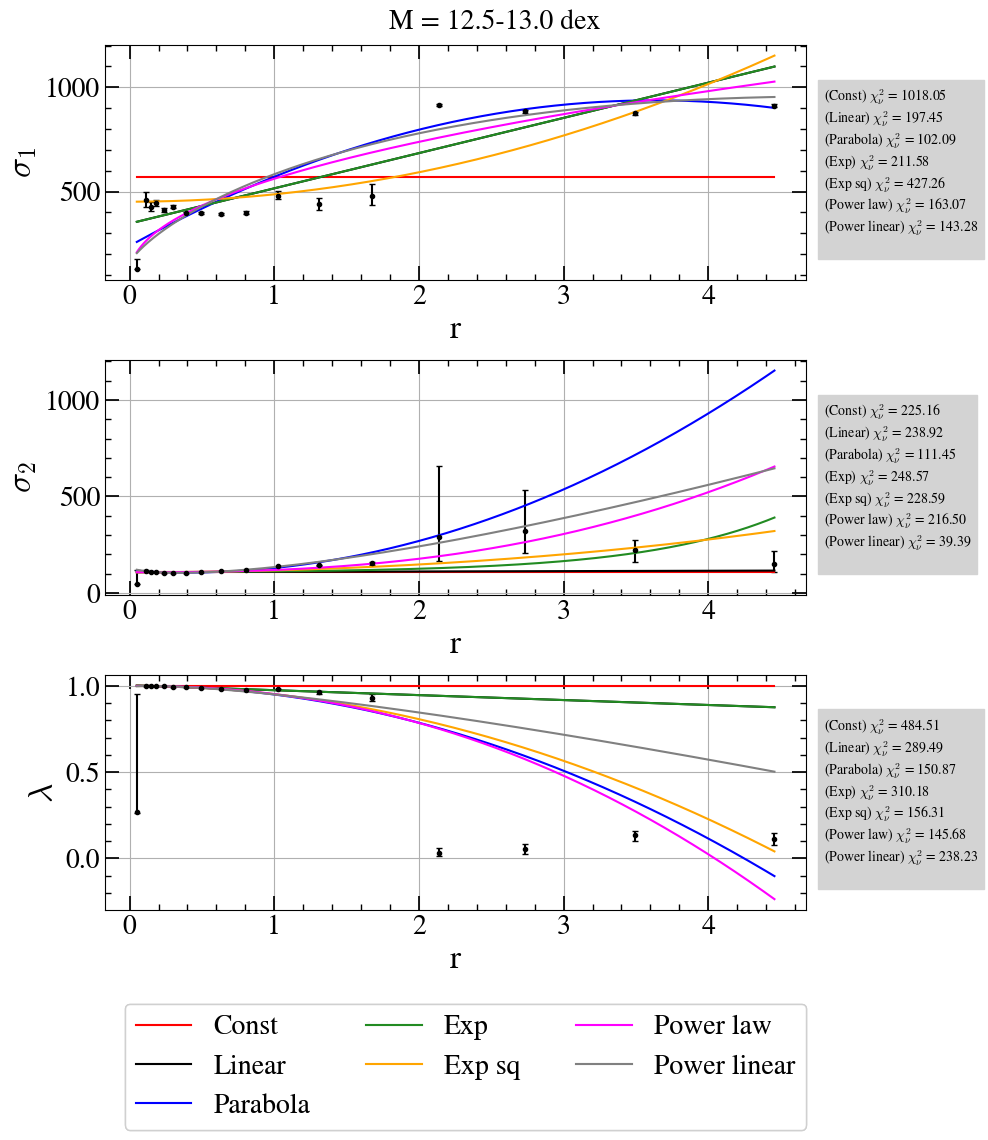

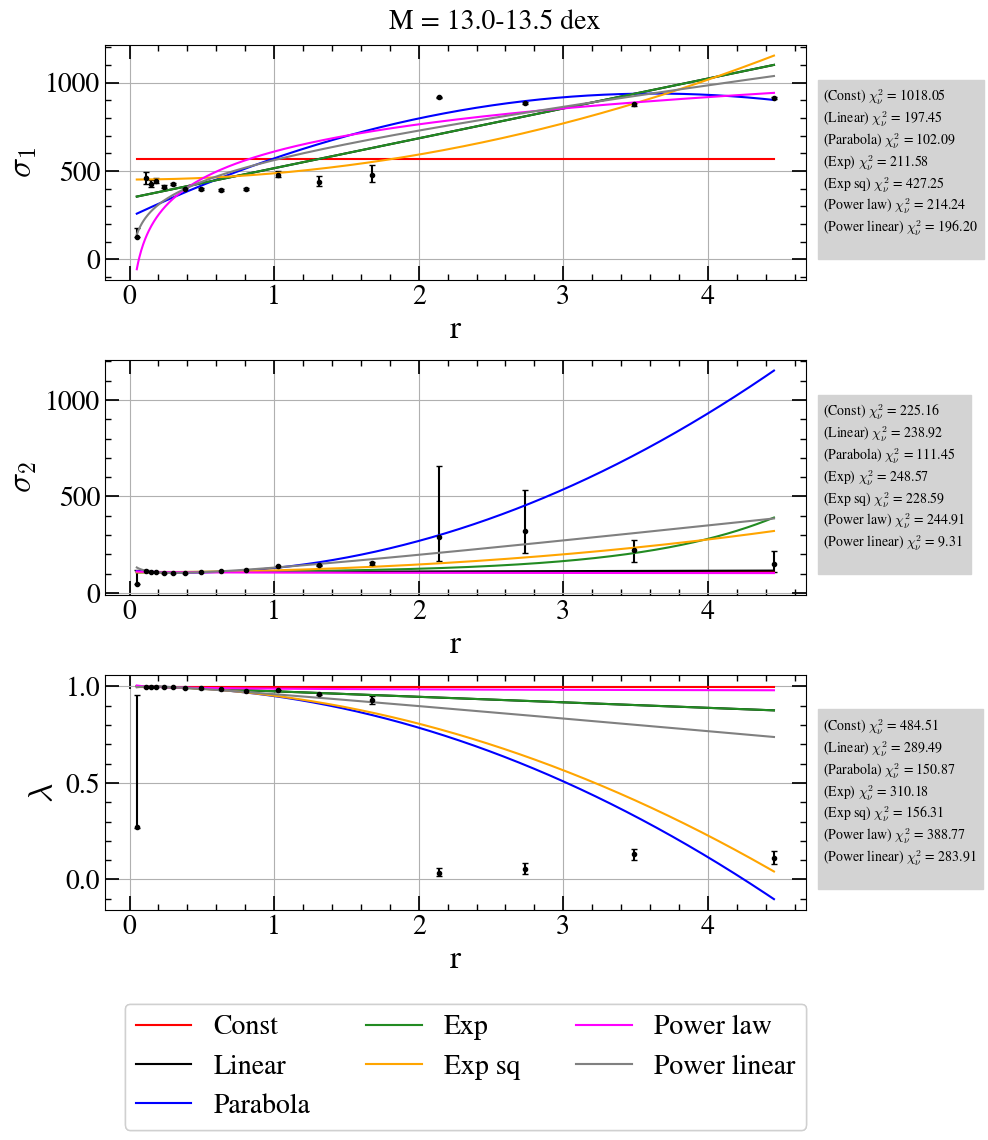

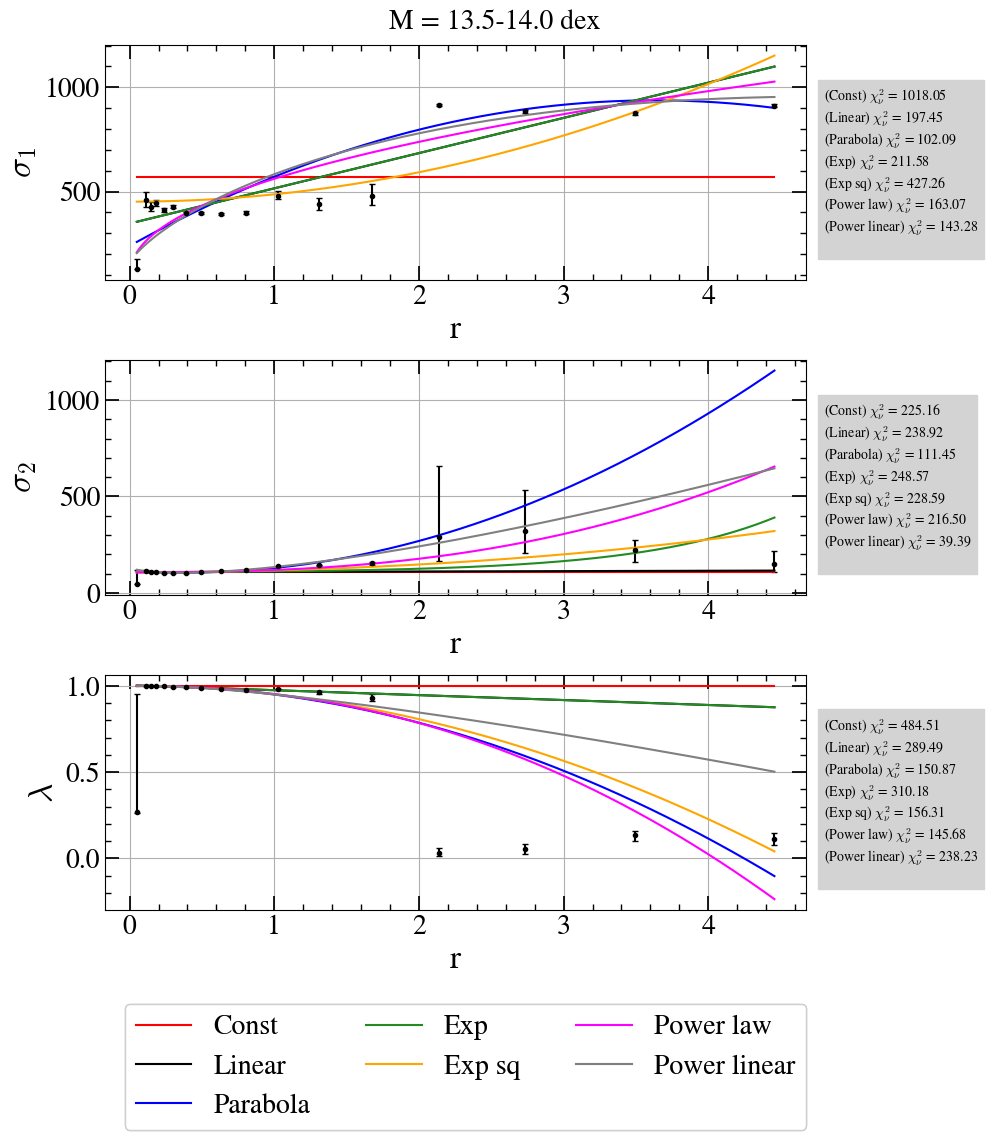

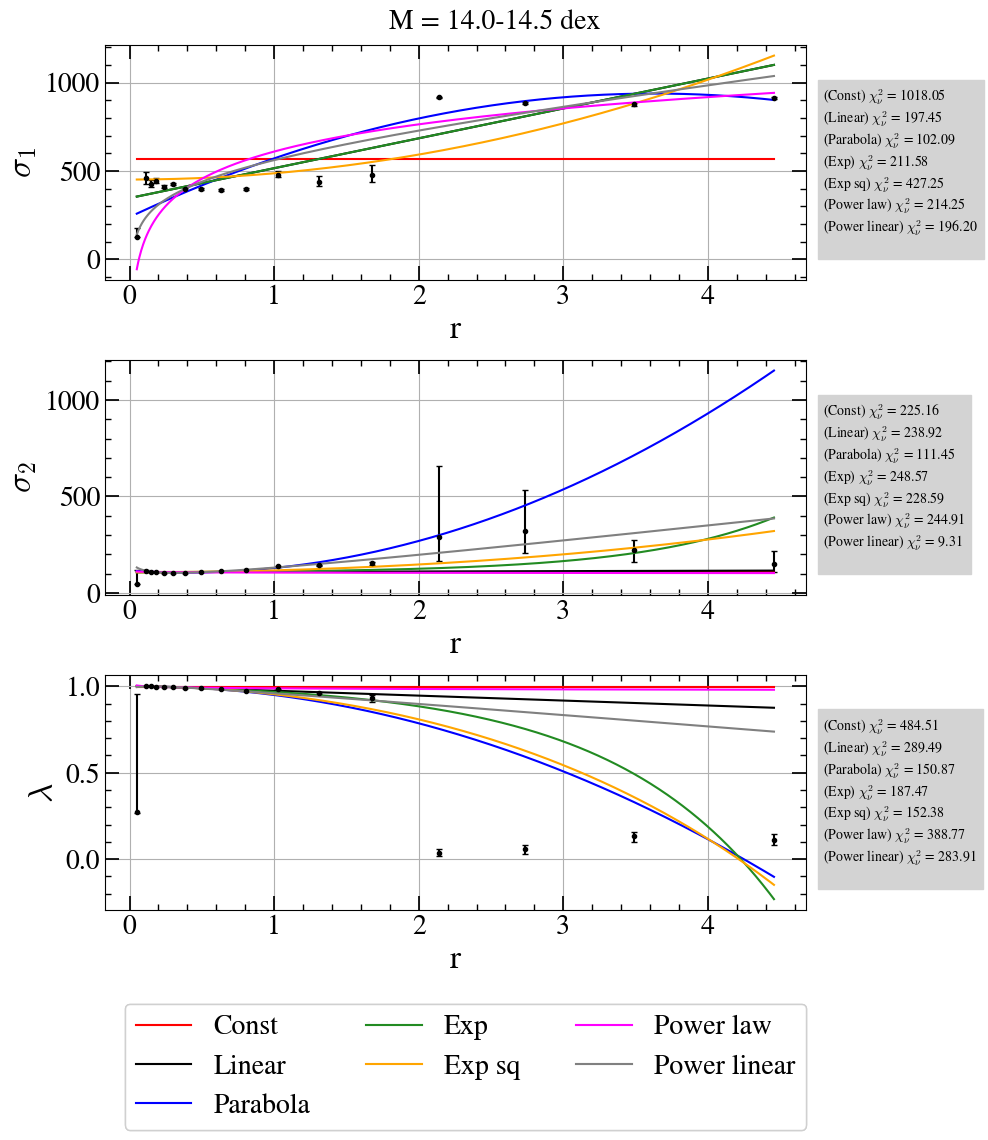

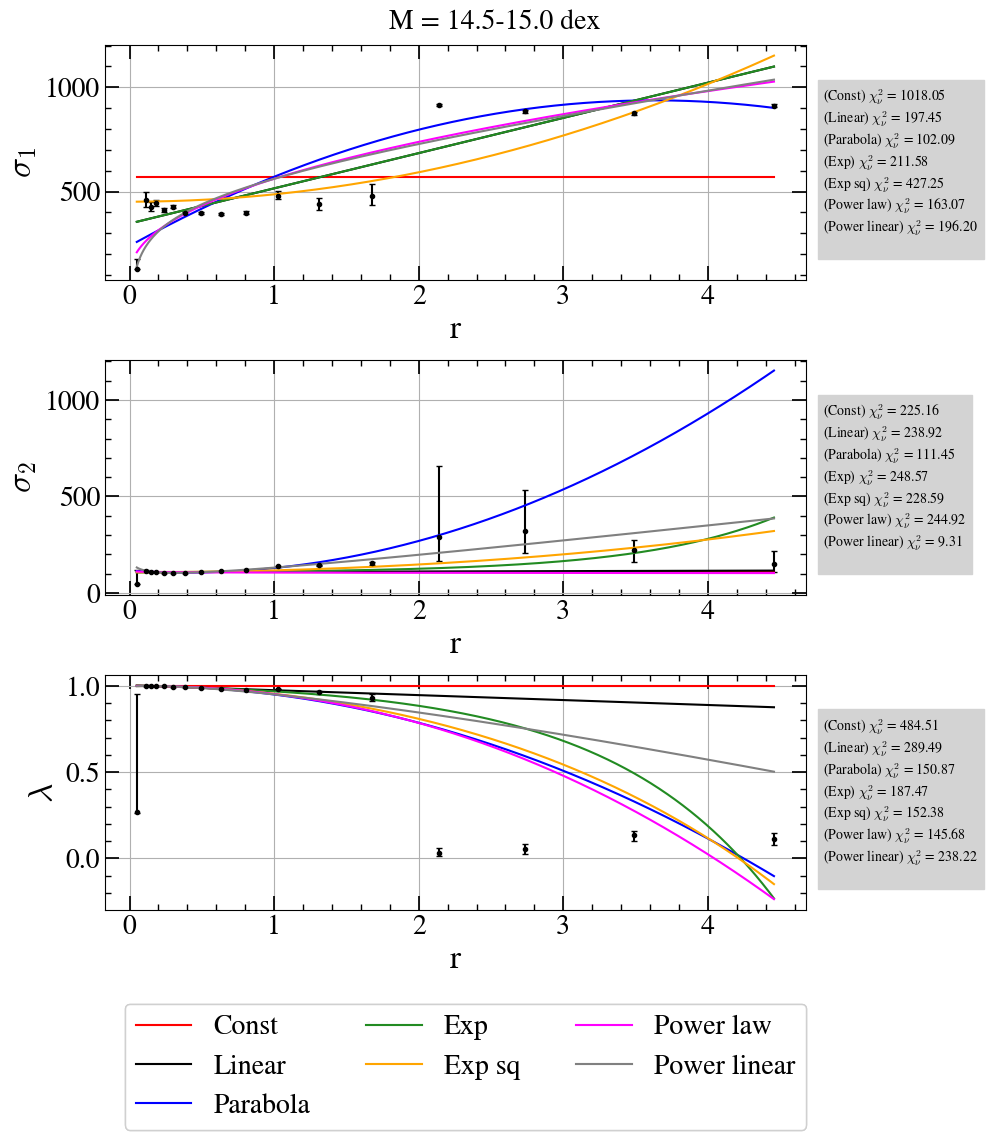

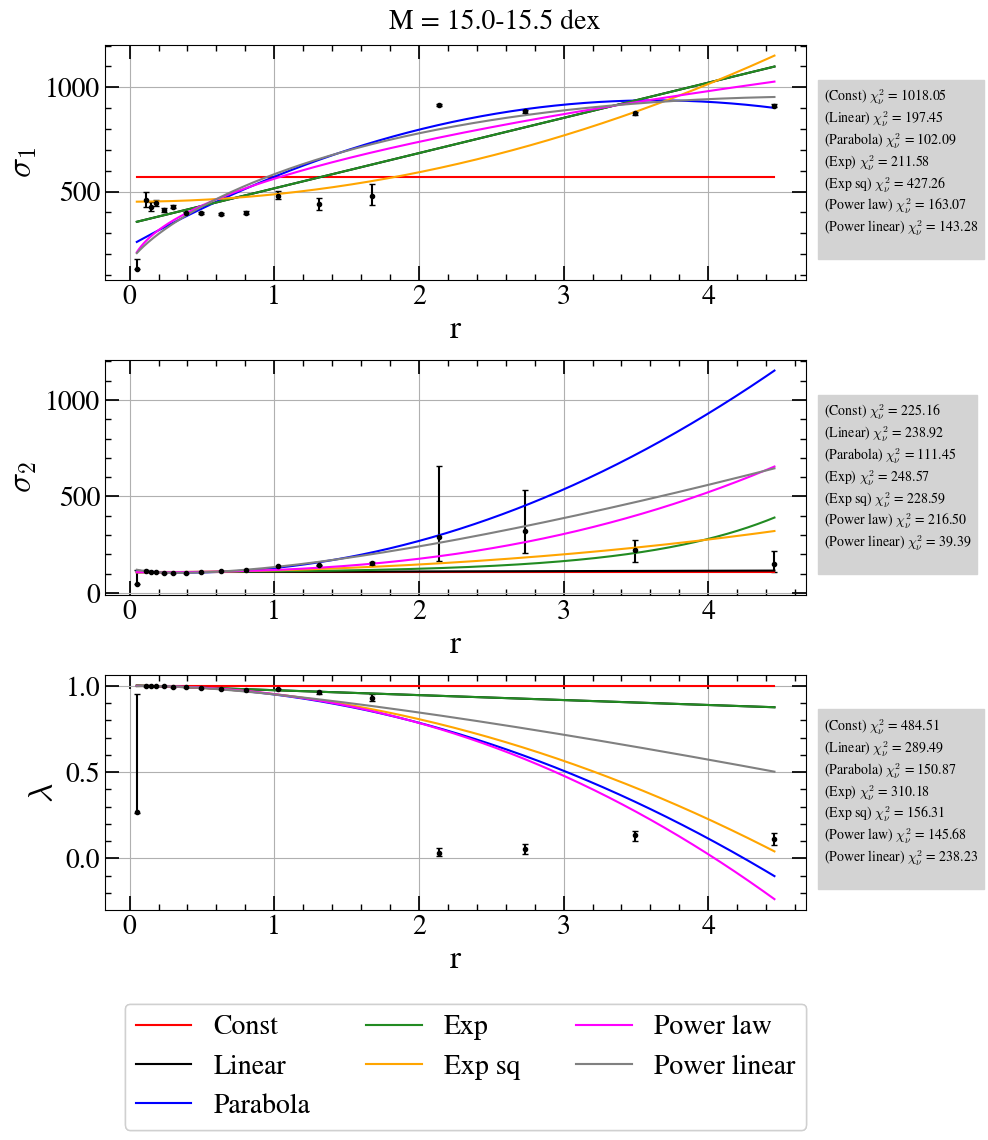

In [5]:
all_funcs = [const_func, linear_func, parabola_func, exp_func, exp_sq_func, power_law_func, power_linear_func]
func_names = [f.__name__.split('_func')[0] for f in all_funcs]
colors = ['red', 'black', 'blue', 'forestgreen', 'orange', 'magenta', 'gray']
color_dict = dict(zip(func_names,colors))
func_dict = dict(zip(func_names, all_funcs))


def reduced_chi2(O, E, sigma, dof):
    return np.sum(np.square(O - E) / sigma** 2) / dof


def fit_all_forms():
    
    for key, mass_bin_dict in mass_dict.items():
        mass_bin_dict = mass_dict['M_12.0-12.5']

        # print(initial_params)
        if key in ['M_12.0-12.5','M_12.5-13.0','M_15.0-15.5']: # these are all 0 since Sowmya didn't do them before
            mkey = 'M_13.5-14.0'
        else:
            mkey = key
        initial_params = initial_params_full[mkey]

        # initial params based on sowmya's results and for the new function based on those
        # need only be in the ballpark
        power_linear_init = np.array([initial_params[x] for x in ['p', 'n', 'q', 'b']])
        linear_init = np.array([initial_params[x] for x in ['m', 'c']])
        exp_init = np.array([initial_params[x] for x in ['A', 'B', 'C']])
        exp_sq_init = exp_init.copy()
        power_law_init = power_linear_init.copy()[:-1]
        const_init = 400.
        parabola_init = np.hstack(([1], linear_init))

        init_list = [const_init, linear_init, parabola_init, exp_init, exp_sq_init, power_law_init, power_linear_init]

        fig, axes = plt.subplots(nrows = 3, figsize = (10,10), sharex = False)
        no_err = [True, True, True]
        for i,(param, values) in enumerate(mass_bin_dict.items()):
            if 'errors' in param:
                continue
        
            match param:
                case 'sigma_1':
                    err = mass_bin_dict['sigma1_errors']
                    
                case 'sigma_2':
                    err = mass_bin_dict['sigma2_errors']

                case 'lambda':
                    err = mass_bin_dict['lambda_errors']
                    
                    # values[len(values)-4:] = 1 - np.array(values[len(values)-4:])

            valid_idx = np.array(values) != -1

            #plot the data
            axes[i].errorbar(rbin_centers[valid_idx], np.array(values)[valid_idx],
                                yerr = err[valid_idx].transpose(), fmt = '.', capsize = 2, color = 'black')
            
            # loop over all functions for this parameter in this mass bin
            paramstr = ''
            for fit_func, func_name, init in zip(all_funcs,func_names,init_list):
                try:
                    xdata = rbin_centers[valid_idx]
                    ydata = np.array(values)[valid_idx]
                    errs = np.mean(err[valid_idx], axis = 1)
                    popt, pcov = curve_fit(fit_func, xdata = xdata, ydata = ydata,
                                            p0 = init, maxfev = 5000,
                                            sigma = errs)
                    err_flag = False

                except RuntimeError:
                    print(f'ERROR OCCURED IN MASS BIN {key} FOR {param} on function {func_name}')
                    err_flag = True
                    no_err[i] = False

                if not err_flag:
                    pretty_func_label = f'{func_name[0].upper()}{func_name[1:].replace('_',' ')}'
                    # every function has a different number of parameters
                    num_args = len(popt)
                    dof = rbin_centers[valid_idx].size - num_args
                    chi2 = reduced_chi2(ydata, fit_func(xdata, *popt), errs, dof)
                    paramstr += f'({pretty_func_label}) ' + r'$\chi^2_{\nu}$ = ' + f'{chi2:.2f}\n'

                    xvalues = np.linspace(np.min(rbin_centers[valid_idx]),np.max(rbin_centers[valid_idx]), 1000)
                    yvalues = fit_func(xvalues, *popt)
                    axes[i].plot(xvalues, yvalues, label = pretty_func_label, c = color_dict[func_name])

            axes[i].text(1.025,0.125,paramstr,fontsize=10,backgroundcolor='lightgray',zorder=-1,transform=axes[i].transAxes)


            try:
                j = np.where(no_err)[0][0]
            except IndexError:
                j = -1

            handles, labels = axes[j].get_legend_handles_labels()
            fig.legend(handles, labels, bbox_to_anchor = [0.825, 0], ncols = 3)
            # make plot prettier
            axes[i].set(ylabel = latex_formatter[param])
            axes[i].set(xlabel = 'r')
            axes[i].ticklabel_format(useOffset=False)
            axes[i].grid()

        plt.suptitle(key.replace('_',' = ')+' dex', fontsize = 20)
        plt.tight_layout()
        plt.show()

fit_all_forms()

### Random stuff

In [ ]:
SOAP_PATH_DEFAULT = "/net/hypernova/data2/FLAMINGO/L1000N1800/HYDRO_FIDUCIAL/SOAP-HBT/halo_properties_0077.hdf5"

# parser = argparse.ArgumentParser()
# parser.add_argument('-M1','--lower_mass', type = np.float32, default = 2, help = 'Lower bound of the mass range in dex above 10^10 Msun. This is inclusive! Defaults to 2.')
# parser.add_argument('-M2','--upper_mass', type = np.float32, default = 5.5, help = 'Upper bound of the mass range in dex above 10^10 Msun. This is inclusive! Defaults to 5.5.') #always EXCLUSIVE upper bound
# parser.add_argument('-S', '--step', type = np.float32, default = 0.5, help = 'Size of bins in dex. Defaults to 0.5.')
# parser.add_argument('-P', '--path_to_soap', type = str, default = SOAP_PATH_DEFAULT, help = 'Path specifying the SOAP-HBT data to be used. Should point to SOAP hdf5 file. Defaults to L1000N1800 @ z= 0.')
# parser.add_argument('-O', '--overwrite', type = int, default = 1, help = 'If a catalogue already exist, control whether to overwrite it. 1 for True, 0 for False.')
# parser.add_argument('-B', '--bins', type = int, default = 100, help = 'Number of velocity bins')
# parser.add_argument('-M', '--method', type = str, default = 'emcee', help = 'Fitting procedure. Choose either emcee, minimize or both.')
# parser.add_argument('-V', '--verbose', type = int, default = 1, help = 'Whether to print diagnostics and timings. 1 for True, 0 for False.')

# args = parser.parse_args()

lower_mass = 2
upper_mass = 5.5
step = 0.5

mass_range = np.arange(lower_mass, upper_mass + step, step).astype(np.float32)
mass_bins = np.array([[mass_range[i],mass_range[i+1]] for i in range(len(mass_range)-1)])

BASEPATH = '/disks/cosmodm/vdvuurst'
data_dir = os.path.join(BASEPATH,f'data/OneHalo_{step}dex')

for mass_bin in reversed(mass_bins): # High mass bins first, since these have the least entries
    filename =  f'M_1{mass_bin[0]}-1{mass_bin[1]}.hdf5'
    filepath =  os.path.join(data_dir,filename)
    file_exists = os.path.isfile(filename)

    filehead = filename.split('.hdf5')[0]
    # print(filepath)
    fitter = ONEHALO.ONEHALO_fitter(PATH = filepath, initial_param_file = f'/disks/cosmodm/vdvuurst/data/OneHalo_param_fits/minimize/{filehead}.json', joint = False)

    r_steps = 18
    rbins = modified_logspace(0, 5, r_steps) 

    for i in range(r_steps - 1): 
        rbin = (rbins[i], rbins[i+1])
        radial_mask = (rbin[0]**2 <= fitter.rel_sq_dist) & (fitter.rel_sq_dist <= rbin[1]**2)
        # print(f'M_1{mass_bin[0]}-1{mass_bin[1]}/r_{rbin[0]:.2f}-{rbin[1]:.2f} has {radial_mask.sum()} datapoints')
        if radial_mask.sum()*3 < 100: #TODO: maybe put in a minimum? like a 100. below that it's not statistically viable anyway
            datapath = f'/disks/cosmodm/vdvuurst/data/OneHalo_param_fits/minimize/M_1{mass_bin[0]}-1{mass_bin[1]}/r_{rbin[0]:.2f}-{rbin[1]:.2f}.json'
            figurepath = f'/disks/cosmodm/vdvuurst/figures/minimize_results_radial_bins/M_1{mass_bin[0]}-1{mass_bin[1]}/r_{rbin[0]:.2f}-{rbin[1]:.2f}_fit.png'
            print(f"{figurepath} exists: {os.path.isfile(figurepath)}")
            if os.path.isfile(datapath):
                os.remove(datapath)
            if os.path.isfile(figurepath):
                print('removing')
                os.remove(figurepath)

/disks/cosmodm/vdvuurst/figures/minimize_results_radial_bins/M_12.5-13.0/r_3.07-3.92_fit.png exists: False
/disks/cosmodm/vdvuurst/figures/minimize_results_radial_bins/M_12.5-13.0/r_3.92-5.00_fit.png exists: False
/disks/cosmodm/vdvuurst/figures/minimize_results_radial_bins/M_12.0-12.5/r_1.88-2.40_fit.png exists: False
/disks/cosmodm/vdvuurst/figures/minimize_results_radial_bins/M_12.0-12.5/r_2.40-3.07_fit.png exists: False
/disks/cosmodm/vdvuurst/figures/minimize_results_radial_bins/M_12.0-12.5/r_3.07-3.92_fit.png exists: False
/disks/cosmodm/vdvuurst/figures/minimize_results_radial_bins/M_12.0-12.5/r_3.92-5.00_fit.png exists: False


### Calculating the G-statistic (and subsequent Q-value) of the fitting procedures

In [ ]:
from scipy.special import gammainc

def Gstat(O,E):
    """G-test statistic.

    Args:
        O (array): Observed counts. MUST be integers.
        E (array): Expected counts under the null hypothesis e.g. the model predictions.

    Returns:
        G (float): The G-statistic value
    """
    G = 0
    for i, Oi in enumerate(O):
        if Oi == 0:
            continue
        G += Oi * np.log(Oi/E[i])
    return 2*G


def get_Qvalue(param_dict, data, **kwargs):
    bins = kwargs['bins']

    bin_heights, bin_edges = np.histogram(data, bins = bins, density=False)
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
    hist_area=np.sum(bin_heights)

    model = hist_area * np.array([mod_gaussian_integral(param_dict['sigma_1'], param_dict['sigma_2'], param_dict['lambda'],
                                                               bin_edges[i], bin_edges[i+1]) for i in range(len(bin_centers))])
    
    Gval = Gstat(bin_heights, model) 

    #dof = 4 since three parameters and 1 extra less since if N -1 bins are filled we know exactly the Nth bin count
    return Qval(Gval, len(bin_heights) - 4)

def Qval(x,k):
    """Find the Q-value aka p-value from a given chi^2 distributed statistic.

    Args:
        x (float): Statistic value
        k (int): The degrees of freedom of the problem.

    Returns:
        Q (float): The Q-value of the statistic given the degrees of freedom.
    """

    #gammainc in scipy is the *regularized* incomplete lower gamma function so /gamma(k/2) is implicit
    return 1 - gammainc(k/2,x/2)

def chi2stat(O, E):
    return np.sum(np.square(O - E) / E)


# def mod_gaussian_integral(sigma1,sigma2,lambda_,x_i,x_f):
#     # integral,_= quad(lambda x: ONEHALO.ONEHALO_fitter.mod_gaussian(x,sigma1,sigma2,lambda_), x_i, x_f)
#     # print('function called')
#     integral, err = Romberg(x_i, x_f, lambda x: ONEHALO.ONEHALO_fitter.mod_gaussian(x,sigma1,sigma2,lambda_))
#     return integral

mod_gaussian_integral = ONEHALO.mod_gaussian_integral

In [ ]:
param_fits_dir = '/disks/cosmodm/vdvuurst/data/OneHalo_param_fits/emcee'

for i,param_file in enumerate(sorted(os.listdir(param_fits_dir))):
    
    emcee_param_path = os.path.join(param_fits_dir, param_file)
    min_param_path = os.path.join(param_fits_dir.replace('emcee','minimize'), param_file)

    param_tail = param_file.split('.json')[0]
    path_to_hdf5 = f'/disks/cosmodm/vdvuurst/data/OneHalo_0.5dex/{param_tail}.hdf5'
    with h5py.File(path_to_hdf5, 'r') as handle:
        # rel_pos = handle['rel_pos'][:]
        rel_vels = handle['rel_vels'][:]    

    if os.path.isdir(emcee_param_path) or os.path.isdir(min_param_path):
        print(emcee_param_path)
        continue

    print(f'WORKING ON MASSBIN {param_tail}')

    with open(emcee_param_path, 'r') as f:
        emcee_param_dict = json.load(f)
    
    with open(min_param_path, 'r') as f:
        min_param_dict = json.load(f)
    

    bin_heights, bin_edges = np.histogram(rel_vels, bins=200, density=False)
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
    bin_width= bin_edges[1] - bin_edges[0] 
    bin_widths = np.diff(bin_edges)  # The width of each bin
    number_density = bin_heights / bin_widths  # Normalize by bin width

    hist_area=np.sum(bin_heights)

    emcee_model = hist_area * np.array([mod_gaussian_integral(emcee_param_dict['sigma_1'], emcee_param_dict['sigma_2'], emcee_param_dict['lambda'],
                                                               bin_edges[i], bin_edges[i+1]) for i in range(len(bin_centers))])

    min_model = hist_area * np.array([mod_gaussian_integral(min_param_dict['sigma_1'], min_param_dict['sigma_2'], min_param_dict['lambda'],
                                                               bin_edges[i], bin_edges[i+1]) for i in range(len(bin_centers))])
    
    print(f"{sum(emcee_model) = }, {sum(min_model) = }, {sum(bin_heights) = }")
    Gval_emcee = Gstat(bin_heights, emcee_model)
    Gval_min = Gstat(bin_heights, min_model) 

    #dof =4 since three parameters and 1 extra less since if N -1 bins are filled we know exactly the Nth bin count
    Qval_emcee = Qval(Gval_emcee, len(bin_heights) - 4)
    Qval_min = Qval(Gval_min, len(bin_heights) - 4) 
    print(f'{Gval_emcee = }, {Qval_emcee = }')
    print(f'{Gval_min = }, {Qval_min = }')
    better = 'emcee' if Qval_emcee > Qval_min else 'minimize'
    if Qval_emcee == Qval_min: better = 'neither'
    print(f'{better} is better ({abs(Qval_min - Qval_emcee)} difference)')
    print()


    # ## Trying chi^2
    # chi2_emcee = chi2stat(bin_heights, emcee_model)
    # chi2_min = chi2stat(bin_heights, min_model)

    # #dof =4 since three parameters and 1 extra less since if N -1 bins are filled we know exactly the Nth bin count
    # Qval_emcee = Qval(chi2_emcee, len(bin_heights) - 4)
    # Qval_min = Qval(chi2_min, len(bin_heights) - 4) 
    # print(f'{chi2_emcee = }, {Qval_emcee = }')
    # print(f'{chi2_min = }, {Qval_min = }')
    # better = 'emcee' if Qval_emcee > Qval_min else 'minimize'
    # if Qval_emcee == Qval_min: better = 'neither'
    # print(f'{better} is better ({abs(Qval_min - Qval_emcee)} difference)')
    # print()
    




    


/disks/cosmodm/vdvuurst/data/OneHalo_param_fits/emcee/M_12.0-12.5
WORKING ON MASSBIN M_12.0-12.5
sum(emcee_model) = np.float64(1921743.017897379), sum(min_model) = np.float64(1921742.9699275545), sum(bin_heights) = np.int64(1921743)
Gval_emcee = np.float64(37928.383048651274), Qval_emcee = np.float64(0.0)
Gval_min = np.float64(38714.23412690983), Qval_min = np.float64(0.0)
neither is better (0.0 difference)

/disks/cosmodm/vdvuurst/data/OneHalo_param_fits/emcee/M_12.5-13.0
WORKING ON MASSBIN M_12.5-13.0
sum(emcee_model) = np.float64(2097537.0353301624), sum(min_model) = np.float64(2097537.046243963), sum(bin_heights) = np.int64(2097537)
Gval_emcee = np.float64(9306.32283495141), Qval_emcee = np.float64(0.0)
Gval_min = np.float64(9222.002859031241), Qval_min = np.float64(0.0)
neither is better (0.0 difference)

/disks/cosmodm/vdvuurst/data/OneHalo_param_fits/emcee/M_13.0-13.5
WORKING ON MASSBIN M_13.0-13.5
sum(emcee_model) = np.float64(2002412.9697038797), sum(min_model) = np.float64(20

### Emcee tests

In [ ]:
reload(ONEHALO)

PATH  = "/disks/cosmodm/vdvuurst/data/OneHalo_0.5dex/M_13.5-14.0.hdf5"
fitter = ONEHALO.ONEHALO_fitter(PATH, initial_param_file='/disks/cosmodm/vdvuurst/data/OneHalo_param_fits/minimize/M_13.5-14.0.json')

res,err = fitter.fit_to_data(method='emcee', verbose = True, nwalkers = 8, nsteps = 500, save_params = True)
# print("Autocorrelation time: {0:.2f} steps".format(sampler.get_autocorr_time()[0]))

/disks/cosmodm/vdvuurst/ONEHALO.py:181: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(mu_i)) + 1. #+1. for integral
  0%|          | 0/500 [00:00<?, ?it/s]/disks/cosmodm/vdvuurst/RSDenv/lib64/python3.12/site-packages/emcee/moves/mh.py:58: RuntimeWarning: invalid value encountered in subtract
  lnpdiff = new_log_probs - state.log_prob + factors
  1%|          | 3/500 [00:17<48:12,  5.82s/it]  


KeyboardInterrupt: 

In [ ]:
reload(ONEHALO)
PATH  = "/disks/cosmodm/vdvuurst/data/OneHalo_0.5dex/M_13.5-14.0.hdf5"
fitter = ONEHALO.ONEHALO_fitter(PATH, initial_param_file='/disks/cosmodm/vdvuurst/data/OneHalo_param_fits/minimize/M_13.5-14.0.json')
init_params = np.array(list(fitter.initial_param_dict.values()))
sigma1, sigma2, lambda_ = init_params

bin_heights, bin_edges = np.histogram(fitter.rel_vels, bins=70, density=False)
# old = fitter.mod_gaussian_reg(fitter.rel_vels, sigma1, sigma2, lambda_)
# new = fitter.mod_gaussian(fitter.rel_vel_sq, sigma1, sigma2, lambda_)

In [ ]:
np.exp(fitter.rel_vel_sq * (-1/sigma1**2 + 1/sigma2**2))

array([0.90937627, 0.58165299, 0.99993737, ..., 0.82270952, 0.79201359,
       0.84851433], shape=(1860222,))

In [ ]:
%%timeit -r 7 -n 1
fitter.mod_gaussian_reg(fitter.rel_vels, sigma1, sigma2, lambda_) #as sowmya wrote it

1.67 s ± 306 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [ ]:
%%timeit -r 7 -n 1
fitter.mod_gaussian_test(fitter.rel_vel_sq, sigma1, sigma2, lambda_) # small optimization with pre-calced vel_sq

The slowest run took 5.76 times longer than the fastest. This could mean that an intermediate result is being cached.
3.73 s ± 1.73 s per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [ ]:
%%timeit -r 7 -n 1
fitter.mod_gaussian(fitter.rel_vel_sq, sigma1, sigma2, lambda_) #through log and above optimization

The slowest run took 5.53 times longer than the fastest. This could mean that an intermediate result is being cached.
306 ms ± 148 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [ ]:
%%timeit -r 7 -n 10
fitter.mod_gaussian_log_likelihood(init_params, fitter.rel_vels)


574 ms ± 162 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [ ]:
%%timeit -r 7 -n 10
fitter.mod_gaussian_log_likelihood_binned(init_params, bin_edges, bin_heights)

158 ms ± 37.4 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [ ]:
from IPython.display import display, Math

labels = [r'\sigma_1', r'\sigma_2', r'\lambda']
for i in range(3):
   txt = r"\mathrm{{{3}}} = {0:.3f}_{{-{1:.3f}}}^{{{2:.3f}}}"
   txt = txt.format(res[i], err[i,0], err[i,1], labels[i])
   display(Math(txt))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

### OneHalo tests and timings

In [ ]:
def mod_gaussian(x,sigma,sigma1,lambda_):
    return ((1-lambda_)* (np.exp(-(x)**2 / (2 * sigma**2)) /sigma ) +lambda_*np.exp(-((x)**2/(2*sigma1**2)))/sigma1)/ (np.sqrt(2*np.pi))

def mod_gaussian_integral(sigma,sigma1,lambda_,x_i,x_f):
    integral,_=quad(lambda x: mod_gaussian(x,sigma,sigma1,lambda_), x_i, x_f) #quad is not necessary, romberg is better
    return integral
    

def mod_gaussian_neg_log_likelihood_binned(params, bin_edges, bin_heights, bin_width):
    sigma,sigma1,lambda_=params
    hist_area=np.sum(bin_heights) 
    fit_integral =1
    A=hist_area/ fit_integral
    neg_log_L=0
    for i in range(1,len(bin_edges)):
        f_b= A* mod_gaussian_integral(sigma,sigma1,lambda_,bin_edges[i-1],bin_edges[i])
        if f_b<=0:
            return 10**11
        n_b=bin_heights[i-1] * bin_width
        neg_log_L+= f_b - (n_b * np.log(f_b))
    return neg_log_L

def mod_gaussian_neg_log_likelihood_binned_romberg(params, bin_edges, bin_heights, bin_width):
    sigma,sigma1,lambda_=params
    hist_area=np.sum(bin_heights) 
    fit_integral =1
    A=hist_area/ fit_integral
    neg_log_L=0
    func = lambda x: mod_gaussian(x, sigma,sigma1,lambda_)
    for i in range(1,len(bin_edges)):
        f_b= A* Romberg(bin_edges[i-1],bin_edges[i], func)
        if f_b<=0:
            return 10**11
        n_b=bin_heights[i-1] * bin_width
        neg_log_L+= f_b - (n_b * np.log(f_b))
    return neg_log_L

In [ ]:
sigma1, sigma2, lambda_ = [278.3, 62.4, 0.26]
%timeit quad_res = mod_gaussian_integral(sigma1, sigma2, lambda_, 0, 0.1)

func = lambda x: mod_gaussian(x, sigma1, sigma2, lambda_)
%timeit rom_res = Romberg(0, 0.1, func = func)
# quad_res, rom_res

106 μs ± 281 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)
357 μs ± 2.3 μs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [ ]:
# hardcoded because these values are taken from sowmya's thesis tables
dic = {}

one = [-227.7, 0.22, 37.6, 396.4, 7.8, 70.9, 0.69, 20, -0.005]
two = [511.3, 1.15, -653.4, 437, -9.42, 104.7, 0.22, 3.03, -0.009]
three = [-505.3, 0.19, 40, 921.9, -4.6, 125.7, 0.1, 1, -0.015]
four = [-554.6, 0.7, 262.4, 1007.8, -7.9, 140, 0.046, 0.45, -0.005]

none_list = np.zeros(9)

tot = [none_list, none_list, one, two, three, four, none_list]

params = ['p', 'n', 'q', 'b', 'm','c','A','B','C']

for i in range(7):
    # dic[f'M{i+1}'] = {'m_low':12+i*0.5, 'm_high':12.5+i*0.5}
    dic[f'M_{12+i*0.5}-{12.5+i*0.5}'] = dict(zip(params,tot[i]))

with open('/disks/cosmodm/vdvuurst/data/initial_params.json', 'w') as file:
    json.dump(dic, file, indent = 1)

In [ ]:
PATH = "/net/hypernova/data2/FLAMINGO/L1000N1800/HYDRO_FIDUCIAL/SOAP-HBT/halo_properties_0077.hdf5"

with h5py.File(PATH, "r") as handle:
    NoofBoundParticles = handle["InputHalos/NumberOfBoundParticles"][:]
    # prelim_mask = _make_nbound_mask(NoofBoundParticles, 100) 
    prelim_mask = np.ones_like(NoofBoundParticles).astype(bool)
    # Full_HaloIndices = np.arange(NoofBoundParticles.size)
    HaloIndices = np.arange(NoofBoundParticles.size)[prelim_mask]
    IsCentral = handle["InputHalos/IsCentral"][:][prelim_mask].astype(bool) #set to bool so it can be used as a mask
    COMvelocity = handle["ExclusiveSphere/100kpc/CentreOfMassVelocity"][:][prelim_mask]
    HaloCatalogueIndex = handle["InputHalos/HaloCatalogueIndex"][:][prelim_mask]
    HostHaloIndex = handle["SOAP/HostHaloIndex"][:][prelim_mask] # -1 for centrals
    COM = handle["ExclusiveSphere/100kpc/CentreOfMass"][:][prelim_mask]
    SOMass = handle['SO/200_mean/TotalMass'][:][prelim_mask]
    # Full_SOMAss =  handle['SO/200_mean/TotalMass'][:]
    # FOFMass=handle["InputHalos/FOF/Masses"][:][prelim_mask]

    boxsize = handle['Header'].attrs['BoxSize'][0]

In [ ]:
NoofBoundParticles.size - HostHaloIndex.max(),NoofBoundParticles.size , HostHaloIndex.max(), HaloIndices[-1], HaloIndices.size

(np.int64(79), 15329653, np.int64(15329574), np.int64(15329652), 15329653)

In [ ]:
np.all(HostHaloIndex[HostHaloIndex!=-1] == HostHaloIndex[~IsCentral])

np.True_

In [ ]:
def _make_mass_mask(mass: np.ndarray, m_min: np.float32, m_max: np.float32) -> np.ndarray:
    if m_min in [0,-1,np.nan, None]:
        return (mass <= 10**m_max)
    elif m_max in [0,-1,np.nan, None]:
        return (10**m_min <= mass)
    return (10**m_min <= mass) & (mass <= 10**m_max) 

lower_mass, upper_mass = 3.5, 4.0

In [ ]:
HostHaloIndex.max(), NoofBoundParticles.size

(np.int64(15329574), 15329653)

In [ ]:
np.unique(HostHaloIndex[~IsCentral])

array([       0,        1,        2, ..., 15329567, 15329569, 15329574],
      shape=(1407835,))

In [ ]:
#move to init
AllCentrals_Idx = HaloIndices[IsCentral]
HostHaloIDs, subhalos_per_host_tot = np.unique(HostHaloIndex[~IsCentral], return_counts = True) # ~IsCentral picks out sattelites
Centrals_wo_sattelites = AllCentrals_Idx[np.invert(np.isin(AllCentrals_Idx, HostHaloIDs))]

print(AllCentrals_Idx.size - (HostHaloIDs.size + Centrals_wo_sattelites.size))
np.isin(HostHaloIDs, AllCentrals_Idx).sum(), HostHaloIDs.size

unaccounted = HostHaloIndex[~IsCentral][~np.isin(HostHaloIndex[~IsCentral], HaloIndices[IsCentral])]
# NoofBoundParticles[unaccounted]
# np.arange(NoofBoundParticles.size)[unaccounted] == unaccounted
# unaccounted_mask = np.isin(HostHaloIndex, unaccounted)
# unaccounted_mask.sum(),unaccounted.size
# HaloIndices[unaccounted_mask],
# Full_SOMAss[unaccounted]
NoofBoundParticles[unaccounted], 

0


(array([], dtype=int64),)

#### Look here for meeting question

In [ ]:
HostHaloIDs, subhalos_per_host_tot = np.unique(HostHaloIndex[~IsCentral], return_counts = True) # ~IsCentral picks out sattelites

# Select the relevant mass range, since the lowest is 10**12 Msol and particle mass is 10^9 
# we do not need to explicitly filter for particle number
mass_mask = _make_mass_mask(SOMass, lower_mass, upper_mass) #functions as a central mask implicitly
HostIndices = HaloIndices[mass_mask] #if it has non-zero mass it must be a central (?)
# print(np.any(NoofBoundParticles[HostIndices] < 100)) #Check just in case

# From the catalogue of sattelite hosting haloes, select only those we know to have data for  
Relevant_Hosts_mask = np.isin(HostHaloIDs,HostIndices)
subhalos_per_host = subhalos_per_host_tot[Relevant_Hosts_mask]
HostIndices = HostHaloIDs[Relevant_Hosts_mask] # This now replaces the previous HostIndices

SatteliteMask = np.isin(HostHaloIndex, HostIndices) #pick out all the sattelites from relevant hosts

# Get the host COM pos and vel, same for sattelites
HostCOMs, HostVels = COM[HostIndices], COMvelocity[HostIndices]
SatSorter = np.argsort(HostHaloIndex[SatteliteMask]) #NOTE: verify if this is necessary
SatCOMs, SatVels = COM[SatteliteMask][SatSorter], COMvelocity[SatteliteMask][SatSorter]
HostPerSat = HostHaloIndex[SatteliteMask][SatSorter]

# This is way quicker than for loop, see below. However this was not the bottleneck of the code so whatever
relative_COMs = SatCOMs - np.repeat(HostCOMs, subhalos_per_host, axis = 0)
relative_vels = SatVels - np.repeat(HostVels, subhalos_per_host, axis = 0)


## SOME CENTRALS DO NOT HAVE SATTELITES i think. I am losing my mind
## this picks them out, in this mass bin there's 12, there's ~300 in total.
mask= ~np.isin(HaloIndices[mass_mask],HostIndices)
missing = HaloIndices[mass_mask][mask]
print(missing, missing.size)
print(f'all missing units are central: {np.all(IsCentral[missing])}')
print(f'What HostHaloIDs are in missing: {np.isin(HostHaloIDs,missing)}') # none of the missing IDs are in HostHaloIDs but ARE centrals
print(f'Is any of the missing present in HostHaloIndex: {np.any(np.isin(HostHaloIndex, missing))}') #None of the missing IDs are in hosthaloindex, so they do not have sattelites


[  130828  2511052  2705729  3113740  3312518  5416483  6940743  7394546
  7749992 11908216 12139199 14121790] 12
all missing units are central: True
What HostHaloIDs are in missing: [False False False ... False False False]
Is any of the missing present in HostHaloIndex: False


### TwoHalo tests

In [ ]:
def change(x,num):
    x = x[np.array(x) < 900]
    new =  np.random.choice(x,num, replace = False)
    x.resize((num,))
    x[:num] = new
    return x


with h5py.File('/disks/cosmodm/vdvuurst/data/test.hdf5','w') as f:
    dset_test = f.create_dataset('test',(100,),maxshape=(1000,), dtype = np.float32)

    dset_test.resize((1000,))
    dset_test[:1000] = np.arange(1000)

    num = 100
    dset_test[:num] = change(dset_test,num)
    dset_test[:num] = change(dset_test, num)
    dset_test.resize((num,))


with h5py.File('/disks/cosmodm/vdvuurst/data/test.hdf5','r') as f:
    test = f['test'][:]


test



array([396., 651., 668., 584., 108., 594., 169., 816., 431., 462., 869.,
       290., 519., 342., 296., 306., 725., 407., 686., 763., 175., 332.,
       237., 330., 598., 535., 496., 702., 480., 214., 738., 426., 489.,
       180., 424., 829., 680.,  31., 254., 554., 586., 485., 533., 312.,
       799., 346., 540., 474., 752., 364., 684., 225., 250., 491., 887.,
       376., 664., 707., 109., 168., 153., 150., 211., 328., 854., 473.,
       672., 852., 741., 890., 893., 871., 273., 387., 896., 544., 843.,
       596., 183., 631., 632., 663., 440., 751., 550., 461., 807., 895.,
       877., 181., 627., 665., 282., 864., 106., 826., 558., 834., 292.,
       196.], dtype=float32)

In [ ]:
totalmax = int(1e7)
wanted = int(1e5)
chance = wanted / totalmax

indices_to_choose = np.random.choice(np.arange(totalmax), wanted, replace = False)
print(indices_to_choose.shape)

with h5py.File('/disks/cosmodm/vdvuurst/data/test.hdf5', 'w') as f:
    dset_radial = f.create_dataset("radial_distances", (wanted,), maxshape=(wanted,), dtype=np.float32)
    counter = 0
    # for i in range(totalmax):
    #     if i not in indices_to_choose:
    #         continue
    for i in indices_to_choose:

        dset_radial[counter] = np.random.randint(low=1,high=100)
        counter += 1

    print(np.nonzero(dset_radial))


(100000,)
(array([    0,     1,     2, ..., 99997, 99998, 99999], shape=(100000,)),)


In [ ]:
pair_data_path = '/disks/cosmodm/vdvuurst/data/M12-15.5_0.5dex/velocity_data_M1_13.5-14.0_M2_14.5-15.0.hdf5'
with h5py.File(pair_data_path,'r') as pair_data:
    radii = pair_data['radial_distances'][:]
    vels = pair_data['velocity_differences'][:]
    prim_masses = pair_data['primary_masses'][:]
    sec_masses = pair_data['secondary_masses'][:]
        
print('data loaded in')
type(sec_masses)

data loaded in


numpy.ndarray

In [ ]:
test = np.arange(0,500,1)
radial_bins = np.logspace(0, np.log10(300), 20)
bin_idx =  np.digitize(test[test <= 300], radial_bins) - 1 # -1 to correct index offset i.e. it will index to the lower bound of the bin
bin_idx = bin_idx[bin_idx != -1]
unique_bins, radial_bin_counts = np.unique(bin_idx, return_counts = True)

# print(bin_idx)
# print(test[bin_idx])
radial_bin_counts.sum()

np.int64(300)

In [ ]:
radial_bins = np.logspace(0, np.log10(300), 20)
bin_idx =  np.digitize(radii, radial_bins) - 1 # -1 to correct index offset i.e. it will index to the lower bound of the bin

unique_bins, radial_bin_counts = np.unique(bin_idx, return_counts = True)
radial_bin_counts[unique_bins == 3]

array([16])

In [ ]:
#NOTE this function is only for subsampling already existing data
def subsample_existing_data(pair_data_path, number_of_bins = 20, max_radius = 300, num_per_bin = int(1e7), overwrite = False):
    # num_per_bin is how many pairs we want to keep per radial bin
    # max_radius is the radial distance cut-off in Mpc

    with h5py.File(pair_data_path,'r') as pair_data:
        radii = pair_data['radial_distances'][:]
        vels = pair_data['velocity_differences'][:]
        prim_masses = pair_data['primary_masses'][:]
        sec_masses = pair_data['secondary_masses'][:]
    
    # Overwrite prim_masses by a new array which is now filled with prim masses to keep the same shape across
    #NOTE this is only relevant for old data so in the future this might become obsolete
    if prim_masses.shape != sec_masses.shape:
        sec_per_prim = sec_masses.shape[0] // prim_masses.shape[0] #we can use integer division because we are sure that this is in fact an integer
        prim_masses = np.array([np.full(sec_per_prim, prim_masses[i]) for i in range(prim_masses.shape[0])]).flatten()
    print('data loaded in')

    #First step is a simple maximum filter
    max_radius_mask = radii <= max_radius
    radii = radii[max_radius_mask]
    vels = vels[max_radius_mask]
    prim_masses = prim_masses[max_radius_mask]
    sec_masses = sec_masses[max_radius_mask]


    radial_bins = np.logspace(0, np.log10(max_radius), number_of_bins)
    bin_idx =  np.digitize(radii, radial_bins) - 1 # -1 to correct index offset i.e. it will index to the lower bound of the bin
    # print(radii[bin_idx == 19][:10])
    # bin_idx = bin_idx[(bin_idx != -1) & (bin_idx != number_of_bins - 1)]#this is the maximum radius filter; all values beyond the bounds are returned as 0 or len(radial_bins) = num_of_bins 
    
    unique_bins, radial_bin_counts = np.unique(bin_idx, return_counts = True)

    if overwrite:
        new_filepath = pair_data_path
    else:
        head, tail = os.path.split(pair_data_path)
        new_dir = os.path.join('/disks/cosmodm/vdvuurst/data', os.path.split(head)[1] + '_subsampled')
        if not os.path.isdir(new_dir):
            os.mkdir(new_dir)
        new_filepath = os.path.join(new_dir, tail) 

   # How many do we keep in the new dataset; we set a per radial bin ceiling
    dset_shape = radial_bin_counts[radial_bin_counts <= num_per_bin].sum() +\
                 radial_bin_counts[radial_bin_counts > num_per_bin].shape[0] * num_per_bin
    
    with h5py.File(new_filepath,'w') as f:
        dset_radial = f.create_dataset("radial_distances", (dset_shape,), dtype=np.float32)
        dset_velocities = f.create_dataset("velocity_differences", (dset_shape,), dtype=np.float32)
        dset_sec_masses = f.create_dataset("secondary_masses", (dset_shape,), dtype=np.float32)
        dset_prim_masses = f.create_dataset("primary_masses", (dset_shape,), dtype=np.float32)

        write_pointer = 0
        # for i,(bin,bin_count) in enumerate(zip(radial_bins,radial_bin_counts)):
        for i in range(number_of_bins):
            if i not in unique_bins: #i.e. there are no halo pairs in this radial bin
                continue

            bin_count = radial_bin_counts[unique_bins == i][0] #some low radius bins may not have any pairs so this is correct indexing
            if bin_count <= num_per_bin: 
                bin_mask = (bin_idx == i)
                dset_radial[write_pointer:write_pointer + bin_count] = radii[bin_mask]
                dset_velocities[write_pointer:write_pointer + bin_count] = vels[bin_mask]
                dset_sec_masses[write_pointer:write_pointer + bin_count] = sec_masses[bin_mask]
                dset_prim_masses[write_pointer:write_pointer + bin_count] = prim_masses[bin_mask]

                write_pointer += bin_count
                continue
            
            #if the above catches aren't activated we have to subsample
            bin_mask = bin_idx == i
            radii_in_bin = radii[bin_mask]
            velocities_in_bin = vels[bin_mask]
            sec_masses_in_bin = sec_masses[bin_mask]
            prim_masses_in_bin = prim_masses[bin_mask]

            # WE LOSE ORDERING! is this bad? not if we lose the ordering in the same way across the dsets
            subsample_idx = np.random.choice(radii_in_bin.shape[0], num_per_bin, replace = False)
            dset_radial[write_pointer:write_pointer + num_per_bin] = radii_in_bin[subsample_idx]
            dset_velocities[write_pointer:write_pointer + num_per_bin] = velocities_in_bin[subsample_idx]
            dset_sec_masses[write_pointer:write_pointer + num_per_bin] = sec_masses_in_bin[subsample_idx]
            dset_prim_masses[write_pointer:write_pointer + num_per_bin] = prim_masses_in_bin[subsample_idx]

            write_pointer += num_per_bin
    
pair_data_path = '/disks/cosmodm/vdvuurst/data/M12-15.5_0.5dex/velocity_data_M1_13.5-14.0_M2_14.5-15.0.hdf5'
subsample_existing_data(pair_data_path, overwrite = False)

data loaded in


In [ ]:
#NOTE this function is only for subsampling non-written data, so the input is the datasets created in TWOHALO.py 
# and before writing they're altered (requires reshaping)
def subsample_data(radii,vels,prim_masses,sec_masses, number_of_bins = 20, max_radius = 300, num_per_bin = int(1e7), overwrite = False):
    # num_per_bin is how many pairs we want to keep per radial bin
    # max_radius is the radial distance cut-off in Mpc

    #First step is a simple maximum filter
    max_radius_mask = np.array(radii) <= max_radius
    radii = radii[max_radius_mask]
    vels = vels[max_radius_mask]
    prim_masses = prim_masses[max_radius_mask]
    sec_masses = sec_masses[max_radius_mask]

    radial_bins = np.logspace(0, np.log10(max_radius), number_of_bins)
    bin_idx =  np.digitize(radii, radial_bins) - 1 # -1 to correct index offset i.e. it will index to the lower bound of the bin

    unique_bins, radial_bin_counts = np.unique(bin_idx, return_counts = True)

   # How many do we keep in the new dataset; we set a per radial bin ceiling
    dset_shape = radial_bin_counts[radial_bin_counts <= num_per_bin].sum() +\
                 radial_bin_counts[radial_bin_counts > num_per_bin].shape[0] * num_per_bin
    
    subsampled_radii = np.zeros(dset_shape)
    subsampled_vels = np.zeros(dset_shape)
    subsampled_prim_masses = np.zeros(dset_shape)
    subsampled_sec_masses = np.zeros(dset_shape)

    write_pointer = 0
    for i in range(number_of_bins):
        if i not in unique_bins: #i.e. there are no halo pairs in this radial bin
            continue

        bin_count = radial_bin_counts[unique_bins == i][0] #some low radius bins may not have any pairs so this is correct indexing
        if bin_count <= num_per_bin: 
            bin_mask = (bin_idx == i)
            subsampled_radii[write_pointer:write_pointer + bin_count] = radii[bin_mask]
            subsampled_vels[write_pointer:write_pointer + bin_count] = vels[bin_mask]
            subsampled_prim_masses[write_pointer:write_pointer + bin_count] = prim_masses[bin_mask]
            subsampled_sec_masses[write_pointer:write_pointer + bin_count] = sec_masses[bin_mask]

            write_pointer += bin_count
            continue
        
        #if the above catches aren't activated we have to subsample
        bin_mask = bin_idx == i
        radii_in_bin = radii[bin_mask]
        velocities_in_bin = vels[bin_mask]
        sec_masses_in_bin = sec_masses[bin_mask]
        prim_masses_in_bin = prim_masses[bin_mask]

        # WE LOSE ORDERING! is this bad? not if we lose the ordering in the same way across the dsets
        subsample_idx = np.random.choice(radii_in_bin.shape[0], num_per_bin, replace = False)
        subsampled_radii[write_pointer:write_pointer + num_per_bin] = radii_in_bin[subsample_idx]
        subsampled_vels[write_pointer:write_pointer + num_per_bin] = velocities_in_bin[subsample_idx]
        subsampled_prim_masses[write_pointer:write_pointer + num_per_bin] = prim_masses_in_bin[subsample_idx]
        subsampled_sec_masses[write_pointer:write_pointer + num_per_bin] = sec_masses_in_bin[subsample_idx]

        write_pointer += num_per_bin

    return subsampled_radii, subsampled_vels, subsampled_prim_masses, subsampled_sec_masses

    ## THIS SHOULD BE DONE OUTSIDE OF THE FUNCTION SINCE THE MAX RADIUS FILTER CREATES A COPY
    ## NOTE the copy takes up even more memory albeit temporary

    # #here we have to resize which is a little slow
    # radii.resize(dset_shape)
    # vels.resize(dset_shape)
    # prim_masses.resize(dset_shape)
    # sec_masses.resize(dset_shape)

    # radii[:dset_shape] = subsampled_radii
    # vels[:dset_shape] = subsampled_vels
    # prim_masses[:dset_shape] = subsampled_prim_masses
    # sec_masses[:dset_shape] = subsampled_sec_masses


In [ ]:
head, tail = os.path.split(pair_data_path)
new_dir = os.path.join('/disks/cosmodm/vdvuurst/data', os.path.split(head)[1] + '_subsampled')
if not os.path.isdir(new_dir):
    os.mkdir(new_dir)
new_filepath = os.path.join(new_dir, tail) 
new_filepath

'/disks/cosmodm/vdvuurst/data/M12-15.5_0.5dex_subsampled/velocity_data_M1_13.5-14.0_M2_14.5-15.0.hdf5'

In [ ]:
overwrite = False
new_filepath = pair_data_path if overwrite else pair_data_path.split('.hdf5')[0]+'_subsampled.hdf5'
new_filepath

'/disks/cosmodm/vdvuurst/data/M12-15.5_0.5dex/velocity_data_M1_13.5-14.0_M2_14.5-15.0_subsampled.hdf5'

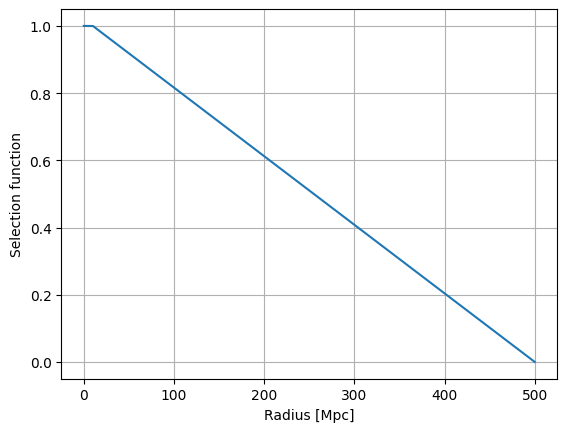

In [ ]:
def func(x):
    func = np.zeros_like(x)
    range = (10 <= x) & (x <= 500)
    func[range] = (-1/490)*x[range] + 1 + (10/490)
    return func

radius = np.arange(0,500,0.01)
selection_function = np.ones_like(radius)
selection_function[radius > 10] = func(radius[radius > 10])

plt.plot(radius,selection_function)
# plt.hlines(0,0,500,colors='black')
# plt.semilogx()
plt.grid()
plt.xlabel('Radius [Mpc]')
plt.ylabel('Selection function')
plt.show()

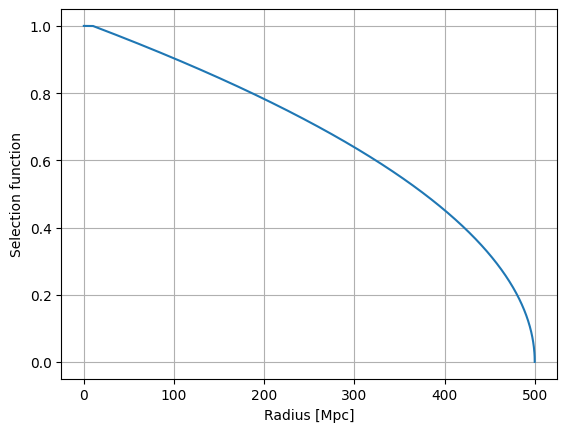

In [ ]:
def func2(x, alpha = 0.5):
    return np.power((500 - x)/490, alpha)

radius = np.linspace(0,500,1+2**12)
selection_function = np.ones_like(radius)
selection_function[radius > 10] = func2(radius[radius > 10])

plt.plot(radius,selection_function)
# plt.hlines(0,0,500,colors='black')
# plt.semilogx()
plt.grid()
plt.xlabel('Radius [Mpc]')
plt.ylabel('Selection function')
plt.show()

In [ ]:
with h5py.File('/disks/cosmodm/vdvuurst/data/M12-15.5_0.5dex/velocity_data_M1_13.0-13.5_M2_13.5-14.0.hdf5','r') as file:
    radius = file['radial_distances'][:]



In [ ]:
def func(x,a = 13.365): #value for a works to reduce the probability to ~1% with this equation, emprically found
    return ((-1/490)*x + 1 + (10/490)) / a

radius_cut = radius[radius <= 500]
print(radius_cut.shape[0] / radius.shape[0])
alpha = func(radius_cut)
num = (np.random.rand(radius_cut.shape[0]) < alpha).sum()
num / radius.shape[0]

0.5236270566253007


np.float64(0.009996752027994021)

In [ ]:
mass_range = np.arange(2, 6, 0.5).astype(np.float32)
mass_bins = np.array([[mass_range[i],mass_range[i+1]] for i in range(len(mass_range)-1)])
bin_combis = np.array(list(combinations_with_replacement(mass_bins,2)))

bin_combis+10

array([[[12. , 12.5],
        [12. , 12.5]],

       [[12. , 12.5],
        [12.5, 13. ]],

       [[12. , 12.5],
        [13. , 13.5]],

       [[12. , 12.5],
        [13.5, 14. ]],

       [[12. , 12.5],
        [14. , 14.5]],

       [[12. , 12.5],
        [14.5, 15. ]],

       [[12. , 12.5],
        [15. , 15.5]],

       [[12.5, 13. ],
        [12.5, 13. ]],

       [[12.5, 13. ],
        [13. , 13.5]],

       [[12.5, 13. ],
        [13.5, 14. ]],

       [[12.5, 13. ],
        [14. , 14.5]],

       [[12.5, 13. ],
        [14.5, 15. ]],

       [[12.5, 13. ],
        [15. , 15.5]],

       [[13. , 13.5],
        [13. , 13.5]],

       [[13. , 13.5],
        [13.5, 14. ]],

       [[13. , 13.5],
        [14. , 14.5]],

       [[13. , 13.5],
        [14.5, 15. ]],

       [[13. , 13.5],
        [15. , 15.5]],

       [[13.5, 14. ],
        [13.5, 14. ]],

       [[13.5, 14. ],
        [14. , 14.5]],

       [[13.5, 14. ],
        [14.5, 15. ]],

       [[13.5, 14. ],
        [15.

In [ ]:
PATH = "/net/hypernova/data2/FLAMINGO/L1000N1800/HYDRO_FIDUCIAL/SOAP-HBT/halo_properties_0077.hdf5"

with h5py.File(PATH, "r") as handle:
    COMvelocity = handle["ExclusiveSphere/100kpc/CentreOfMassVelocity"][:]
    HaloCatalogueIndex = handle["InputHalos/HaloCatalogueIndex"][:]
    SOMass = handle['SO/200_mean/TotalMass'][:] #TODO: verify that this is a good choice
    NoofBoundParticles = handle["InputHalos/NumberOfBoundParticles"][:]
    COM = handle["ExclusiveSphere/100kpc/CentreOfMass"][:]
    IsCentral = handle["InputHalos/IsCentral"][:].astype(bool) #set to bool so it can be used as a mask
    boxsize = handle['Header'].attrs['BoxSize'][0]


array([1146.       , 1180.       ,  663.       , ...,    9.8125   ,
          6.9140625,    8.       ], shape=(15329653,), dtype=float32)

In [ ]:
from TWOHALO import _make_mass_mask

mask = _make_mass_mask(SOMass, 2,2.5)

mask.sum()

np.int64(1151840)

In [ ]:
test = np.zeros(10*2).reshape(10,2)
counter = 0
for i in range(5):
    # test[counter:counter+2] = [(1,2),(1,2)]
    test[counter:counter+2] = [(1,2),(1,2)]
    counter += 2

test

array([[1., 2.],
       [1., 2.],
       [1., 2.],
       [1., 2.],
       [1., 2.],
       [1., 2.],
       [1., 2.],
       [1., 2.],
       [1., 2.],
       [1., 2.]])

In [ ]:
mass_range = np.arange(12,16,0.5)
bins = np.array([[mass_range[i],mass_range[i+1]] for i in range(len(mass_range)-1)])
combis = list(combinations_with_replacement(bins,2))
combis,len(combis)

([(array([12. , 12.5]), array([12. , 12.5])),
  (array([12. , 12.5]), array([12.5, 13. ])),
  (array([12. , 12.5]), array([13. , 13.5])),
  (array([12. , 12.5]), array([13.5, 14. ])),
  (array([12. , 12.5]), array([14. , 14.5])),
  (array([12. , 12.5]), array([14.5, 15. ])),
  (array([12. , 12.5]), array([15. , 15.5])),
  (array([12.5, 13. ]), array([12.5, 13. ])),
  (array([12.5, 13. ]), array([13. , 13.5])),
  (array([12.5, 13. ]), array([13.5, 14. ])),
  (array([12.5, 13. ]), array([14. , 14.5])),
  (array([12.5, 13. ]), array([14.5, 15. ])),
  (array([12.5, 13. ]), array([15. , 15.5])),
  (array([13. , 13.5]), array([13. , 13.5])),
  (array([13. , 13.5]), array([13.5, 14. ])),
  (array([13. , 13.5]), array([14. , 14.5])),
  (array([13. , 13.5]), array([14.5, 15. ])),
  (array([13. , 13.5]), array([15. , 15.5])),
  (array([13.5, 14. ]), array([13.5, 14. ])),
  (array([13.5, 14. ]), array([14. , 14.5])),
  (array([13.5, 14. ]), array([14.5, 15. ])),
  (array([13.5, 14. ]), array([15.

In [ ]:
combis = np.array(list(combinations(mass_range,2)))
print(combis)

[[12.  12.5]
 [12.  13. ]
 [12.  13.5]
 [12.  14. ]
 [12.  14.5]
 [12.  15. ]
 [12.  15.5]
 [12.5 13. ]
 [12.5 13.5]
 [12.5 14. ]
 [12.5 14.5]
 [12.5 15. ]
 [12.5 15.5]
 [13.  13.5]
 [13.  14. ]
 [13.  14.5]
 [13.  15. ]
 [13.  15.5]
 [13.5 14. ]
 [13.5 14.5]
 [13.5 15. ]
 [13.5 15.5]
 [14.  14.5]
 [14.  15. ]
 [14.  15.5]
 [14.5 15. ]
 [14.5 15.5]
 [15.  15.5]]


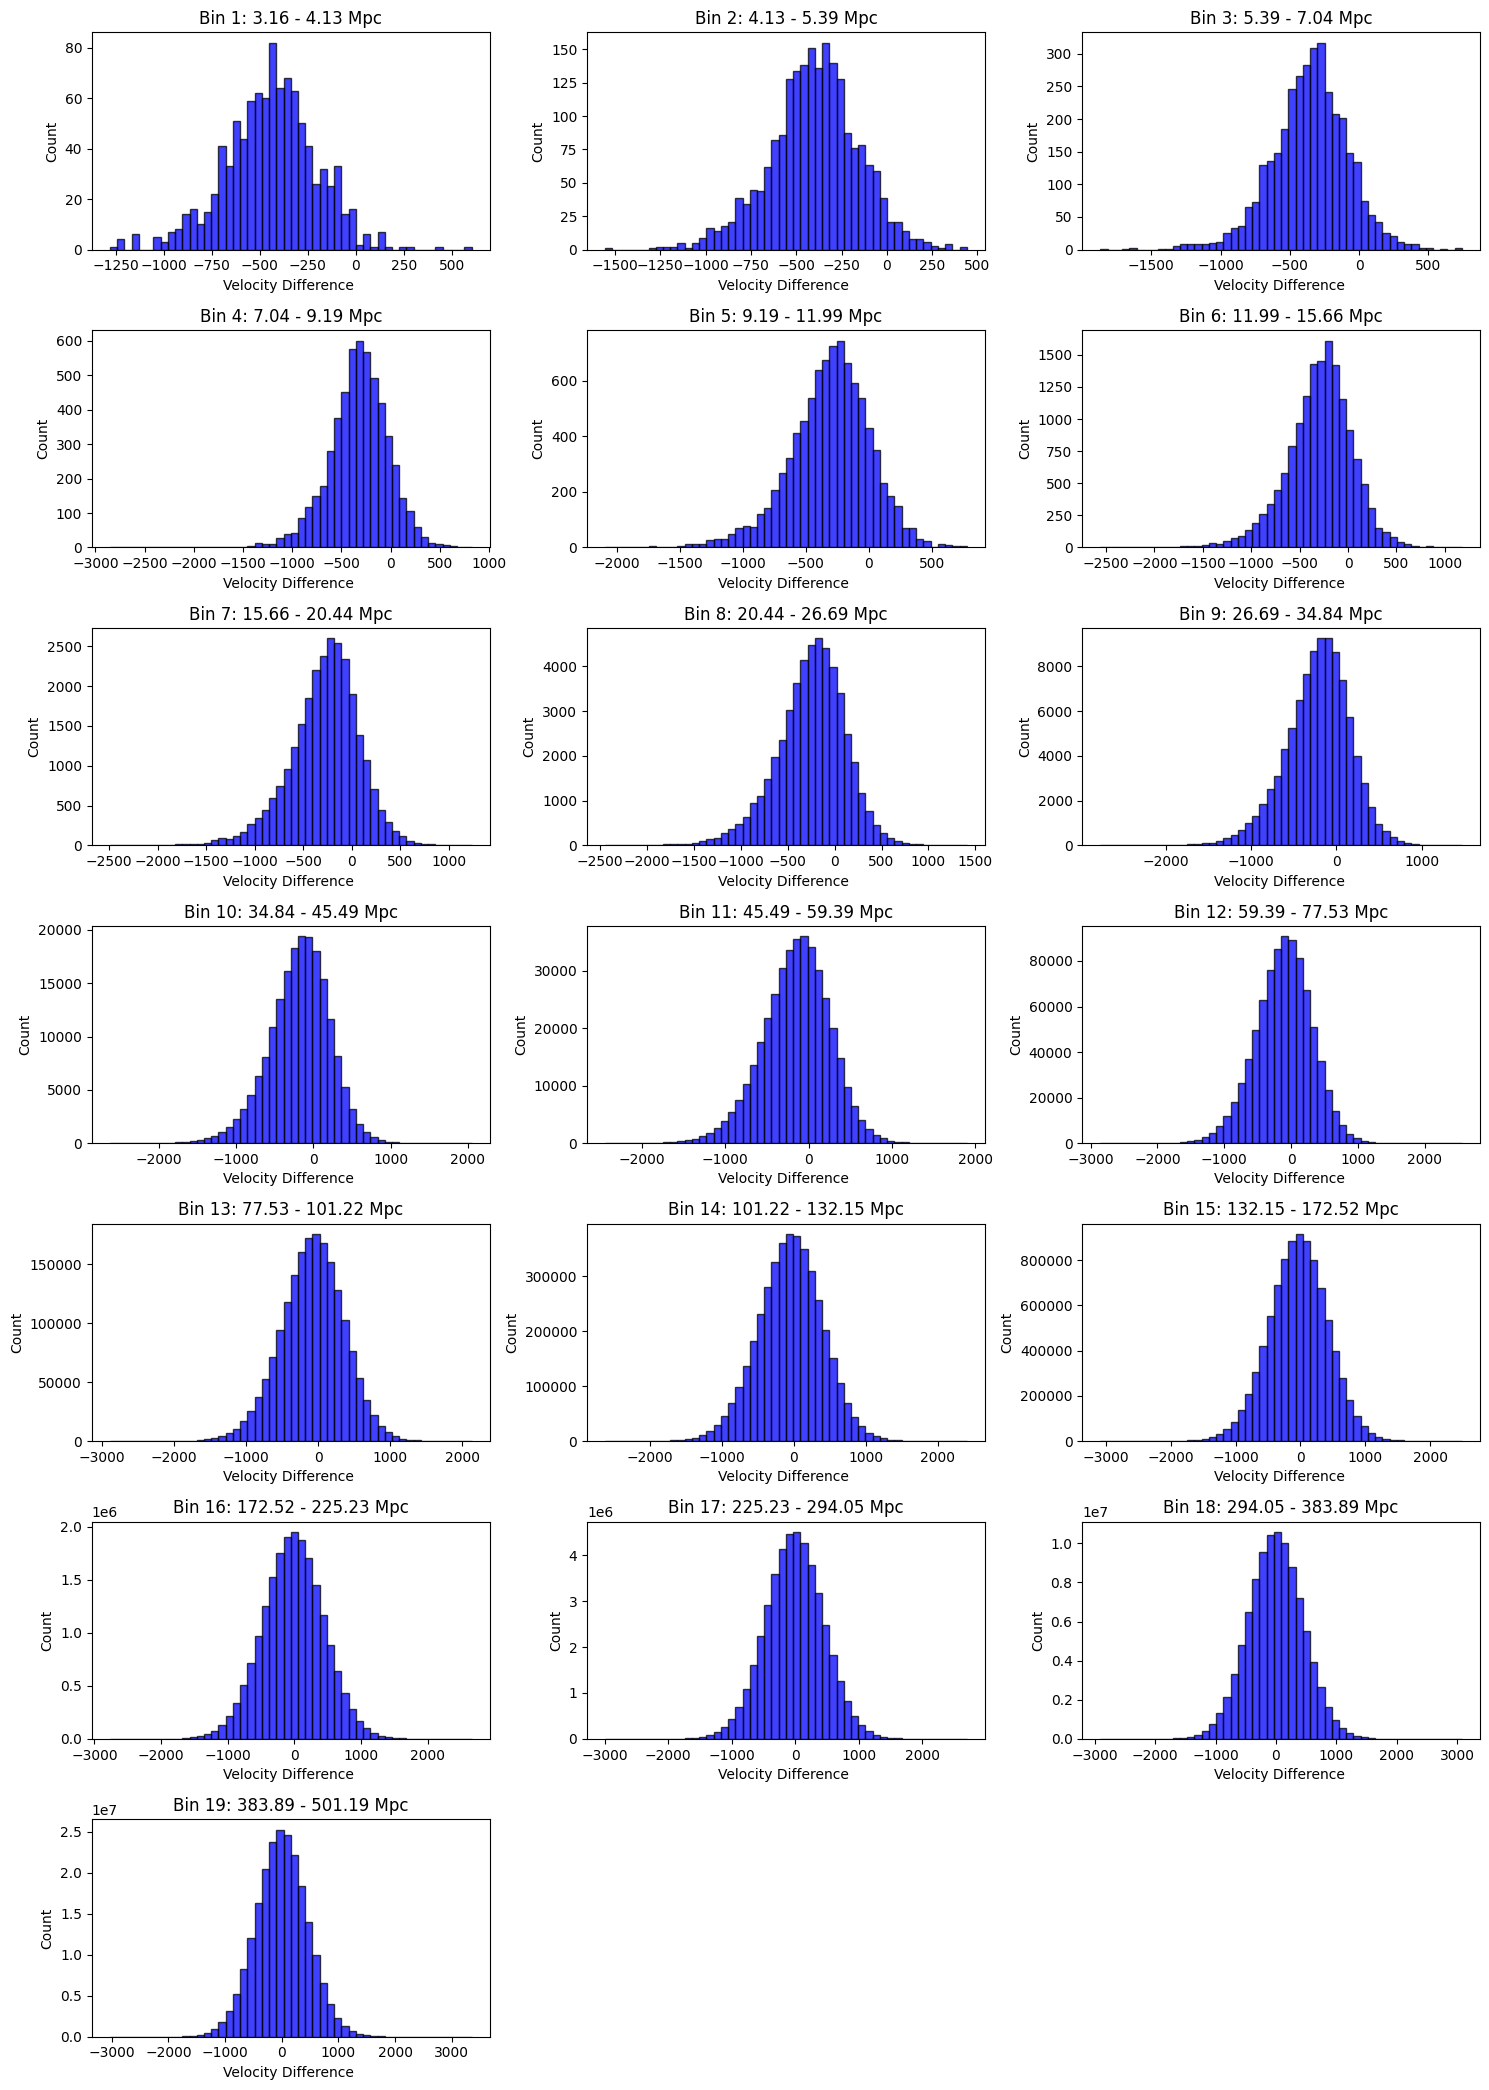

In [ ]:
# Define radial bins
radial_bins = np.logspace(0.5, 2.7, 20).astype(np.float32)

with h5py.File("/disks/cosmodm/vdvuurst/data/velocity_data_M4_4_5.hdf5", "r") as f:
# with h5py.File("velocity_data_M14_14_5_trial_NORMAL_SIGMA_largersecondary_newquantity_lowsigma8.h5", "r") as f:
    radial_distances = f["radial_distances"][:]
    velocities = f["velocity_differences"][:]
    
# np.max(radial_distances)
bin_indices = np.digitize(radial_distances, bins=radial_bins) - 1
num_bins = len(radial_bins) - 1  


num_cols = 3
num_rows = int(np.ceil(num_bins / num_cols))  

fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, num_rows * 3))
axes = axes.flatten()  

mean, dispersion, skews, kurt = [], [], [], []

for bin_idx in range(num_bins):
    bin_mask = bin_indices == bin_idx
    bin_velocities = velocities[bin_mask]
    
    if len(bin_velocities) == 0:
        continue

    mean.append(np.mean(bin_velocities))
    dispersion.append(np.std(bin_velocities))
    skews.append(skew(bin_velocities))
    kurt.append(kurtosis(bin_velocities))
    
    ax = axes[bin_idx]
    ax.hist(bin_velocities, bins=50, alpha=0.75, color='b', edgecolor='black')
    ax.set_xlabel("Velocity Difference ")
    ax.set_ylabel("Count")
    ax.set_title(f"Bin {bin_idx + 1}: {radial_bins[bin_idx]:.2f} - {radial_bins[bin_idx + 1]:.2f} Mpc")


for i in range(num_bins, len(axes)):
    fig.delaxes(axes[i])

plt.tight_layout()
# plt.savefig("velocity_histograms_new2halo.png", dpi=700)
plt.show()


In [ ]:
radial_distances.shape[0]

767657375

## Plot of the moments of the distributions

In [ ]:
# radial_bins = np.logspace(0.5, 2.7, 20).astype(np.float32)
radial_bins = np.linspace(np.min(radial_distances),np.max(radial_distances),30).astype(np.float32)
# np.max(radial_distances)
bin_indices = np.digitize(radial_distances, bins=radial_bins) - 1
num_bins = len(radial_bins) - 1  

mean, dispersion, skews, kurt = [], [], [], []

for bin_idx in range(num_bins):
    bin_mask = bin_indices == bin_idx
    bin_velocities = velocities[bin_mask]
    
    if len(bin_velocities) == 0:
        continue

    mean.append(np.mean(bin_velocities))
    dispersion.append(np.std(bin_velocities))
    skews.append(skew(bin_velocities))
    kurt.append(kurtosis(bin_velocities,fisher = False))


In [ ]:
# We define some properties for the figures
SMALL_SIZE = 10 * 2 
MEDIUM_SIZE = 12 * 2
BIGGER_SIZE = 14 * 2

plt.rc('axes', titlesize=SMALL_SIZE)                     # fontsize of the axes title\n",
plt.rc('axes', labelsize=MEDIUM_SIZE)                    # fontsize of the x and y labels\n",
plt.rc('xtick', labelsize=SMALL_SIZE, direction='out')   # fontsize of the tick labels\n",
plt.rc('ytick', labelsize=SMALL_SIZE, direction='out')   # fontsize of the tick labels\n",
plt.rc('legend', fontsize=SMALL_SIZE)                    # legend fontsize\n",
mpl.rcParams['axes.titlesize'] = BIGGER_SIZE
mpl.rcParams['ytick.direction'] = 'in'
mpl.rcParams['xtick.direction'] = 'in'
mpl.rcParams['mathtext.fontset'] = 'cm'
mpl.rcParams['font.family'] = 'STIXgeneral'

mpl.rcParams['figure.dpi'] = 100

mpl.rcParams['xtick.minor.visible'] = True
mpl.rcParams['ytick.minor.visible'] = True
mpl.rcParams['xtick.top'] = True
mpl.rcParams['ytick.right'] = True

mpl.rcParams['xtick.major.size'] = 10
mpl.rcParams['ytick.major.size'] = 10
mpl.rcParams['xtick.minor.size'] = 4
mpl.rcParams['ytick.minor.size'] = 4

mpl.rcParams['xtick.major.width'] = 1.25
mpl.rcParams['ytick.major.width'] = 1.25
mpl.rcParams['xtick.minor.width'] = 1
mpl.rcParams['ytick.minor.width'] = 1

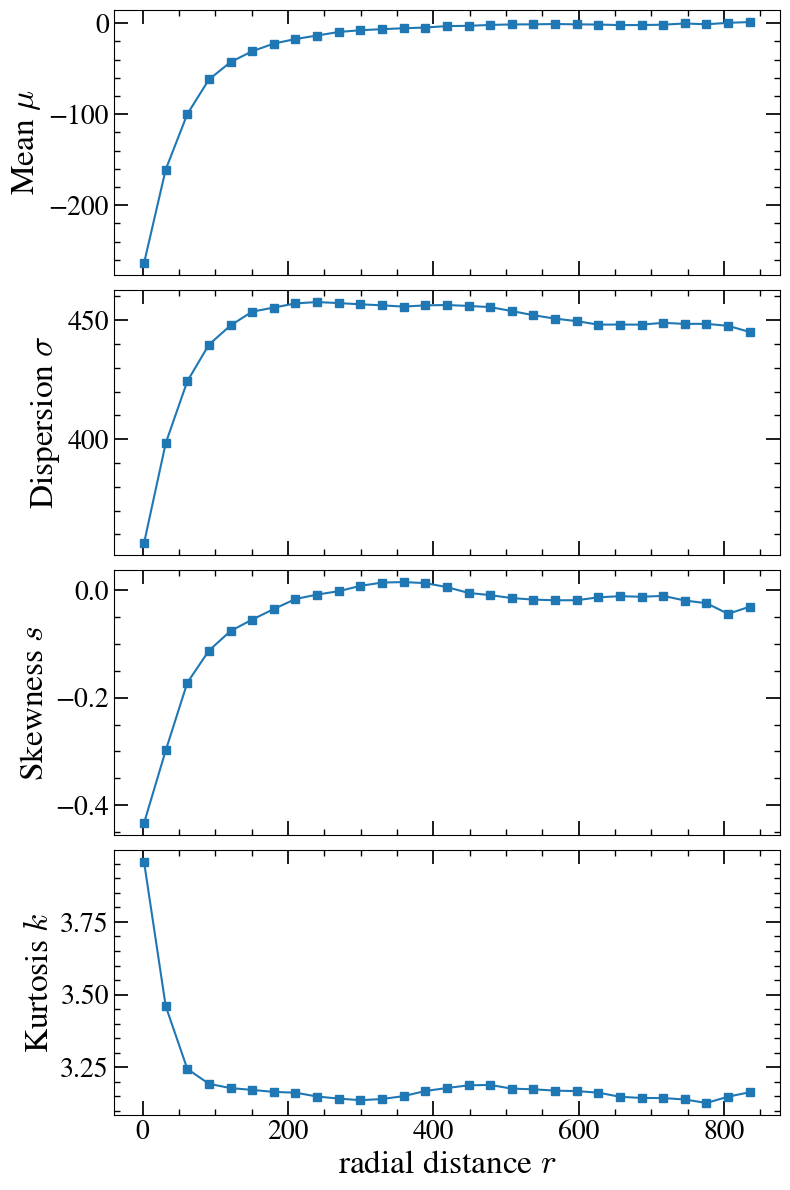

In [ ]:
fig,axes = plt.subplots(nrows = 4,figsize=(8,12), sharex=True, layout='tight')

axes[0].plot(radial_bins[:-1],mean,marker='s')
axes[0].set(ylabel = r'Mean $\mu$')
axes[1].plot(radial_bins[:-1],dispersion, marker = 's')
axes[1].set(ylabel = r'Dispersion $\sigma$')
axes[2].plot(radial_bins[:-1], skews, marker = 's')
axes[2].set(ylabel = r'Skewness $s$')
axes[3].plot(radial_bins[:-1], kurt, marker='s')
axes[3].set(xlabel = r'radial distance $r$', ylabel = r'Kurtosis $k$')

plt.subplots_adjust(wspace = 0, hspace=0)

plt.show()